<a href="https://colab.research.google.com/github/madelgi/pvd-gan-presentation/blob/master/notebooks/gan_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# An Introduction to Generative Adversarial Networks

A generative adversarial network (GAN) is a generative machine learning system developed in 2014, with numerous applications in both supervised and unsupervised contexts. Many of the impressive breakthroughs in generative modeling (e.g., [ThisPersonDoesNotExist.com](https://ThisPersonDoesNotExist.com)) use a GAN-based system behind the scenes. By the end of this talk, I hope to cover:

1. What is a generative model?
2. How do GANs work (in broad strokes)?
3. How would you go about building a simple GAN?
4. What are some examples of the current state-of-the-art in GANs?

**Note**: Because we have a wide range of skill levels in this group, from hobbyists to Ph.D.'s in statistics, my goal isn't to get bogged down in theoretical or engineering details. I want to provide a birds-eye view of what GANs do and how they function. For folks interested in diving deeper, I've sprinkled some exercises throughout the write-up, and I've compiled links to papers and other resources at the end of the notebook.


## Preliminaries 

### Generative vs. Discriminative Models

Broadly, statistical models can be grouped into two categories:

1. **Discriminative**: A discriminative model learns the boundary between classes. Mathematically, we are learning the *conditional* probability distribution $P(Y|X)$.
2. **Generative**: A generative model learns how the data is actually distributed, rather than just the boundaries between different classes. Mathematically, this is equivalent to learning the *joint* probability distribution $P(X, Y)$.
  - A generative model can be transformed into a discriminative model (i.e., used for classification) via Bayes' rule. 


- **Example 1**: Consider a dataset of images of 0's and 1's, and you want to categorize each image as either a 0 or 1. A discriminative model can tell you whether something is a 0 or a 1, but it can't do anything else. A generative model actually understands what 0's and 1's look like, and it can generate new pictures that appear to be 0's or 1's (hence the "generative" in the name). A generative model goes through a slightly less direct process to categorize an image -- it asks, "based on this data model I have, which class (0 or 1) is more likely to produce this image?"  

![generative_v_discriminative](static/generative_v_discriminative.png)


- **Example 2** ([source](https://stackoverflow.com/questions/879432/what-is-the-difference-between-a-generative-and-a-discriminative-algorithm)): Suppose you have the following data:
  
  `(1, 0), (1, 0), (2, 0), (2, 1)`
  
  Then a generative model would learn the following probability distribution `p(x, y)`:
  
  ```
        y=0   y=1
        ----------
  x=1 | 1/2   0
  x=2 | 1/4   1/4
  ```
  
  A discriminative model would learn the following probability distribution `p(y|x)`
  
  ```
        y=0   y=1
        ----------
  x=1 | 1     0
  x=2 | 1/2   1/2
  ```
  
    - **Exercise**: Consider what each distribution would look like if we added 16 more `(1, 0)` points to our dataset.
    - **Exercise**: Think about how you can go from the model `p(x, y)` to `p(y|x)` (read about Bayes' rule). Can you go in the other direction, from `p(y|x)` to `p(x, y)`? Why or why not?
    
- **Which model should I use?**: If you need to generate new data, a generative model is likely the best choice! If you are classifying data, in most situations a discriminative model will produce better results than a generative model. At a high level, this is because the generative model is trying to solve a harder problem (what is the shape of the underlying data distribution) vs. the discriminative model, which is directly trying to solve the issue of classification.
    - **Note**: Reality is slightly more nuanced: [Ng and Jordan](http://papers.nips.cc/paper/2020-on-discriminative-vs-generative-classifiers-a-comparison-of-logistic-regression-and-naive-bayes.pdf) found that, while discriminative models usually outperform generative models for the purposes of classification, in a scenario with limited training data, a generative model may outperform a discriminative model. In their words, "While discriminative learning has lower [...] error, a generative classifier may also approach its (higher) [...] error much faster" (i.e., the learning algorithm will converge faster).



### Neural networks 

TODO this section can be as long or as short as needed. Ideally it would be short, so we can focus more on GANs themselves

## How Do GANs Work?

After all of those preliminaries, we are ready to talk about GANs. Here is a cartoon of a GAN:

![simple_gan](static/simple_gan_diagram.png)

- A GAN is a _system_ of two neural networks, a _Generator_ and _Discriminator_.
- The generator takes as input some sort of random noise (you can just think of this as a seed value, i.e., don't worry about it too much) and outputs some generated data. This generated data is supposed to "spoof" some real data distribution. In the diagram above, our underlying data distribution is pictures of cats. 
- The discriminator takes in images from our real data distribution along with our "spoofed" data, and tries to distinguish between the two. In other words, the discriminator solves a binary classification problem where the two possible classes are "real cat" and "fake cat".

### Training Process

GANs play a game with one another. The generator is responsible for creating data that is supposed to look like data from some other distribution (e.g., images of cats). The discriminator is responsible for distinguishing between real and generated images.

The diagram below is a more detailed version of the diagram earlier in this section, with some expository detail surrounding the training process:

![gan_training](static/gan_training.png)

**Quick notes:**

- Again, the generator and discriminator are both neural networks. They can be incredibly complex, but the above image abstracts that complexity away to focus on the overall training scheme.
- The generator takes as inputs random values pulled from a normal distribution centered at 0, $z\sim N(0,1)$. You can think of this as a seed value. Depending on the problem-type, the input may be more meaningful. E.g., if we were building a GAN to do super-resolution, the input would be a low-resolution image. 
- We represent the neural networks in functional notation, $G$ and $D$:
\begin{align}
G: X\mapsto Y, \quad\quad D: Y\mapsto \{0, 1\}
\end{align}
  $G$ maps values from some input distribution (in this case, $X=N(0,1)$) to some output distribution $Y$ -- in our cat example above, $Y$ might be the space of $32\times 32$ images. The discriminator takes values from $Y$, and tries to determine whether the value comes from our real dataset, or if it has been created by the generator. In the cat image example, if our generator solely produces images of all black pixels, then our discriminator will have a pretty easy time distinguishing those from real cat pictures.

## Building a Simple GAN (and Training Pitfalls)

In this section, we lay out the architecture of a very simple GAN, and explore some of the training difficulties that arise with GANs. We are going to be following [this](https://blog.paperspace.com/implementing-gans-in-tensorflow/) tutorial, but our implementation will be in Keras.

In [2]:
import inspect
import pvd_gan_presentation as pvd

Using TensorFlow backend.
/home/max/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


SyntaxError: invalid syntax (train.py, line 23)

### Problem Statement and Data Set

We are going to use 

### Architecture

As discussed previously, our GAN consists of two components: the generator and discriminator. The generator is responsible for generating data, and the discriminator is responsible for differentiating between generated and "real" data. Execute the two cells below to view the source code and architecture of each of the models.

In [14]:
pvd.PVDDiscriminator??

In [10]:
pvd.PVDGenerator??

### Training: Initial Attempt and Results

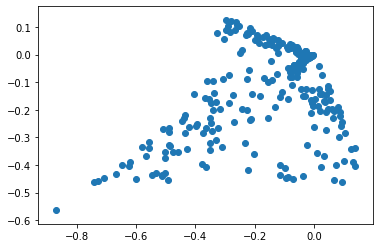

/home/max/anaconda3/envs/pvd-gan/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Iteration 0 [D loss: 0.39345186948776245, acc.: 51.953125] [G loss: None]
Iteration 100 [D loss: 0.07355420291423798, acc.: 0.0] [G loss: 2.042599678039551]
Iteration 200 [D loss: 0.0005733341677114367, acc.: 0.0] [G loss: 6.852892875671387]
Iteration 300 [D loss: 3.547575033735484e-07, acc.: 0.0] [G loss: 14.302242279052734]
Iteration 400 [D loss: 4.1566825537131535e-09, acc.: 0.0] [G loss: 18.793655395507812]
Iteration 500 [D loss: 2.1099559877058027e-09, acc.: 0.0] [G loss: 20.126449584960938]
Iteration 600 [D loss: 8.541060636524378e-10, acc.: 0.0] [G loss: 21.07253646850586]
Iteration 700 [D loss: 5.404268144104662e-10, acc.: 0.0] [G loss: 21.44860076904297]
Iteration 800 [D 

KeyboardInterrupt: 

In [16]:
gen = pvd.PVDGenerator()
disc = pvd.PVDDiscriminator()
trainer = pvd.PVDGAN(generator=gen, discriminator=disc)
trainer.train(visualize=True)



### Optimization Techniques

## Current State of the Art


### StyleGAN 2

- Example usage: ![ThisPersonDoesNotExist](https://thispersondoesnotexist.com/)
- Architecture overview
- Training routine